### Searching the ChEMBL Database for Interesting SAR 
<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_posts/refs/heads/main/chembl_herg/sherlock_robot.png" width=300/>

### 0. Introduction
This analysis is based on a conversation I had with some friends working on the [OpenADMET](https://openadmet.org/) project. One goal of OpenADMET is to identify the structures of ligands bound to off-targets like hERG, an ion channel involved in cardiac liabilities.  Those interested in learning more about strategies for hERG optimization may want to consult [this 2006 paper](https://pubs.acs.org/doi/full/10.1021/jm060379l) from J. Med. Chem. or [this video](https://www.youtube.com/watch?v=-GBhvMpwJl0) from Drug Hunter. 

I thought it would be interesting to find examples in the medicinal chemistry literature where a hERG liability was addressed. I aimed to find congeneric series with a range of hERG activities. Having series that include hERG binders and closely related non-binders can provide insights into strategies for reducing liabilities. If we obtain a cryoEM structure of the hERG binder, can we use it to explain why the inactive analog lacks hERG activity? To explore this, I searched ChEMBL for cases where a team tackled a hERG liability. I conducted a search to identify sets of similar compounds from the same paper with at least a 10-fold difference in hERG activity. This notebook details the steps I took in this process.

Install the necessary Python packages.

In [1]:
%%capture
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install -q rdkit mols2grid ipywidgets tqdm useful_rdkit_utils molbloom

Load the necessary Python libraries

In [20]:
import sqlite3
import pandas as pd
from tqdm.auto import tqdm
import useful_rdkit_utils as uru
import numpy as np
from rdkit import Chem
from molbloom import buy
import mols2grid
from ipywidgets import interact
import os

Enable progress bars for Pandas operations 

In [21]:
tqdm.pandas()

### 1. Download the ChEMBL database 
If in Google Colab download and unzip the ChEMBL database.  This takes about 3.5 minutes. If you're running this notebook locally, change the `db_filename` to reflect the location of your ChEMBL sqlite database.

In [22]:
db_filename = "/Users/pwalters/.data/chembl/35/chembl_35.db"
if IN_COLAB:
    db_filename = "./chembl_35/chembl_35_sqlite/chembl_35.db"
    if not os.path.exists(db_filename):
        !wget https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/chembl_35_sqlite.tar.gz
        !tar -xzf chembl_35_sqlite.tar.gz

### 2. Find the ChEMBL ID for hERG

To begin, we know that the Uniprot ID for hERG is [Q12809](https://www.uniprot.org/uniprotkb/Q12809/entry). To search ChEMBL for compounds tested against hERG, we need to convert that Uniprot ID to a ChEMBL ID. There is a file called `chembl_unitprot_mapping.txt` available on the ChEMBL download site that maps ChEMBL IDs to Uniprot IDs. Let's load that file into a Pandas DataFrame so we can search it.

In [23]:
df = pd.read_csv("https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/chembl_uniprot_mapping.txt",sep="\t",
                comment='#',
                names=['uniprot_id','chembl_id','target_name','target_type'])

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

Now we'll search the dataframe for that Uniprot id. 

In [10]:
df.query("uniprot_id  == 'Q9UNQ0' and target_type == 'SINGLE PROTEIN'")

,uniprot_id,chembl_id,target_name,target_type
2695,Q9UNQ0,CHEMBL5393,ATP-binding cassette sub-family G member 2,SINGLE PROTEIN


### 3. Query the ChEMBL database for hERG data

Create a connection to the ChEMBL database.

In [11]:
conn = sqlite3.connect(db_filename)
cursor = conn.cursor()

Here's the sql query to grab all the hERG data and surrounding information from ChEMBL.  

- **target_dictionary**: Filters targets by chembl_id (CHEMBL240).
- **assays**: Links targets (tid) to assays (assay_id).
- **docs**: Provides document details (doc_id, doi, title).
- **activities**: Connects assays to compound records and provides standard_value and standard_units.
- **compound_records**: Links compound records to molecular structures and provides compound_id.
- **compound_structures**: Extracts canonical_smiles.

In [12]:
sql = """SELECT
    d.doc_id,
    d.doi,
    d.title,
    a.assay_id,
    cr.compound_key,
    cs.molregno,
    cs.canonical_smiles,
    act.standard_type,
    act.standard_value,
    act.standard_relation,
    act.standard_units,
    act.pchembl_value
FROM
    target_dictionary td
        JOIN
    assays a ON td.tid = a.tid
        JOIN
    docs d ON a.doc_id = d.doc_id
        JOIN
    activities act ON a.assay_id = act.assay_id AND d.doc_id = act.doc_id
        JOIN
    compound_records cr ON act.record_id = cr.record_id
        JOIN
    compound_structures cs ON cr.molregno = cs.molregno
WHERE
    td.chembl_id = 'CHEMBL240';"""

Run the query

In [13]:
res = cursor.execute(sql)

Load the results into a Pandas dataframe

In [14]:
df = pd.read_sql_query(sql,conn)
len(df)

30467

In [15]:
df.head(5)

,doc_id,doi,title,assay_id,compound_key,molregno,canonical_smiles,standard_type,standard_value,standard_relation,standard_units,pchembl_value
0,4905,10.1016/s0960-894x(02)00250-0,"4,4-Disubstituted cyclohexylamine NK(1) recept...",220871,5f,75221,CC(C(=O)N[C@]1(c2ccccc2)CC[C@@H](N2CCN(C(C)C)C...,Ki,1200.0,=,nM,5.92
1,4905,10.1016/s0960-894x(02)00250-0,"4,4-Disubstituted cyclohexylamine NK(1) recept...",220871,5i,1595020,CC(C(=O)NC1(c2ccccc2)CCC(N2CCC3(CCCO3)CC2)CC1)...,Ki,730.0,=,nM,6.14
2,4905,10.1016/s0960-894x(02)00250-0,"4,4-Disubstituted cyclohexylamine NK(1) recept...",220871,2,75085,CC(C(=O)N[C@]1(c2ccccc2)CC[C@@H](N2CCC(c3ccc(F...,Ki,43.0,=,nM,7.37
3,4905,10.1016/s0960-894x(02)00250-0,"4,4-Disubstituted cyclohexylamine NK(1) recept...",220871,5b,1595015,CC(C(=O)N[C@]1(c2ccccc2)CC[C@H](N2CCCCC2)CC1)c...,Ki,1200.0,=,nM,5.92
4,4905,10.1016/s0960-894x(02)00250-0,"4,4-Disubstituted cyclohexylamine NK(1) recept...",220871,5c,1595019,CC1CCN([C@H]2CC[C@](NC(=O)C(C)c3cc(C(F)(F)F)cc...,Ki,460.0,=,nM,6.34


Only keep compounds with measured values that don't have an operator (>,<) and have standard units in nM (skip entries with %)

In [16]:
df_ok = df.dropna(subset="pchembl_value").query("standard_relation == '='").query("standard_units == 'nM'").copy()
len(df_ok)

11830

### 4. Extract congeneric series from papers 

The function below processes the structures from a paper and identifies congeneric series.

In [17]:
def get_series_from_paper(input_df):
    res = []
    for k,v in input_df.groupby(["assay_id","standard_type","standard_units"]):
        paper_df = v.copy()
        paper_df['mol'] = paper_df.canonical_smiles.apply(Chem.MolFromSmiles)
        activity_df = paper_df[['doc_id','doi','canonical_smiles','molregno','compound_key','standard_value','assay_id','standard_type','standard_units','pchembl_value']]
        mol_df, scaffold_df = uru.find_scaffolds(paper_df,smiles_col="canonical_smiles",name_col="molregno", disable_progress=True)
        scaffold_smi, out_df = uru.get_molecules_with_scaffold(scaffold_df.Scaffold.values[0], mol_df, activity_df,
                                  smiles_col="canonical_smiles", 
                                  name_col="molregno",
                                  activity_col="standard_value",
                                  extra_cols=["compound_key","assay_id","standard_type","standard_units","doc_id","pchembl_value"])
        out_df.merge(paper_df[["canonical_smiles","molregno","compound_key"]],on=["canonical_smiles","molregno"])
        if len(out_df) > 1:
            res.append([scaffold_smi,out_df])
    return res

As an example, consider [ChEMBL doc_id `117736`](https://www.ebi.ac.uk/chembl/explore/document/CHEMBL4680090).  We'll do a quick search to see the form the results take. 

In [18]:
test_df = df_ok.query("doc_id == 117736")
test_res = get_series_from_paper(test_df)
test_res

[[array(['CC(C)n1cc(C(=O)c2cncc(NC(=O)C[*:3])c2)c2c([*:1])nc([*:2])nc21'],
        dtype=object),
                                      canonical_smiles  molregno  \
  0  CC(C)n1cc(C(=O)c2cncc(NC(=O)Cc3ccc(Cl)cc3)c2)c...   2526613   
  1  CC(C)n1cc(C(=O)c2cncc(NC(=O)Cc3ccc(Cl)cc3)c2)c...   1994374   
  2  CC(C)n1cc(C(=O)c2cncc(NC(=O)Cc3ccc(C#N)cc3)c2)...   1994376   
  3  CC(C)n1cc(C(=O)c2cncc(NC(=O)Cc3ccc(C#N)cc3)c2)...   2531494   
  4  CC(C)n1cc(C(=O)c2cncc(NC(=O)Cn3ccc(C4CC4)n3)c2...   1994395   
  5  CC(C)n1cc(C(=O)c2cncc(NC(=O)Cn3ccc(C4CC4)n3)c2...   1999216   
  6  CC(C)n1cc(C(=O)c2cncc(NC(=O)Cc3ccc(Cl)cc3)c2)c...   1999213   
  
     standard_value compound_key  assay_id standard_type standard_units  doc_id  \
  0         10800.0            3   2027231            Ki             nM  117736   
  1          5200.0            4   2027231            Ki             nM  117736   
  2          7100.0            5   2027231            Ki             nM  117736   
  3          9700.0    

Loop over each paper in `df_ok` and extract the congeneric series. 

In [56]:
df_list = []
for k,v in tqdm(df_ok.groupby("doc_id")):
    if len(v) > 2:
        series_res = get_series_from_paper(v)
        for scaffold_smi, paper_df in series_res:
            if len(scaffold_smi):
                paper_df['doi'] = v.doi.values[0]
                paper_df['scaffold'] = scaffold_smi[0]
                paper_df.drop_duplicates(["canonical_smiles","molregno"],inplace=True)
                df_list.append(paper_df)

  0%|          | 0/1576 [00:00<?, ?it/s]

Save the results to a csv file for future reference. 

In [57]:
pd.concat(df_list).to_csv("chembl_hERG_summary.csv",index=False)

Take a look at one example. 

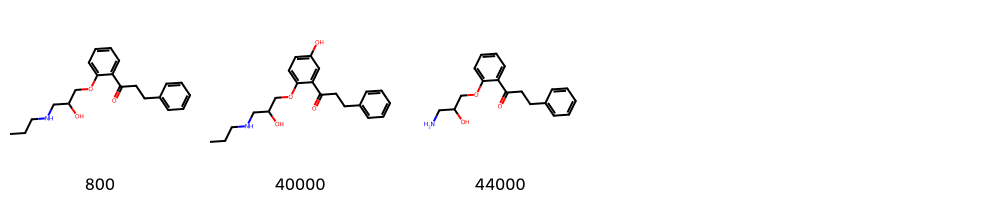

In [23]:
tmp_df = df_list[12].copy()
tmp_df.sort_values("standard_value",inplace=True)
legends = [f"{x:.0f}" for x in tmp_df.standard_value]
Chem.Draw.MolsToGridImage(uru.align_mols_to_template(tmp_df.scaffold.values[0],tmp_df.canonical_smiles),molsPerRow=5,useSVG=True,legends=legends)

Create a dataframe containing the number of structrues from each paper.

In [24]:
combo_df = pd.concat(df_list)
uru.value_counts_df(combo_df,"doi")

,doi,count
0,10.1016/j.bmcl.2011.07.006,56
1,10.1016/j.bmcl.2015.04.002,56
2,10.1016/j.bmcl.2015.06.061,52
3,10.1016/j.bmc.2016.02.031,51
4,10.1016/j.bmcl.2010.04.045,41
...,...,...
741,10.1021/acs.jmedchem.1c01015,2
742,10.1016/j.ejmech.2021.113674,2
743,10.1021/acs.jmedchem.5b01372,2
744,10.1021/jm2013248,2


### 5. Determine which compounds can be purchased
To do this, we will use the [MolBloom](https://github.com/whitead/molbloom) tool created by Andrew White. MolBloom generates a searchable index that allows quick determination of whether a compound is in a database. MolBloom has a simple function `buy`, which returns **True** or **False** indicating whether a compound is commercially available. In this case, we'll use MolBloom to verify that each compound is in the [ZINC](https://cartblanche22.docking.org/) database of commercially available compounds. 

In [25]:
combo_df['purchasable'] = [buy(smi, canonicalize=True) for smi in tqdm(combo_df.canonical_smiles)]

  0%|          | 0/5838 [00:00<?, ?it/s]

Iterate over the compound sets we generated above and only select the ones that are purchasable.

In [26]:
result_list = []
for k,v in combo_df.query("purchasable > 0").groupby(["doc_id","scaffold"]):
    doc_id,scaffold = k
    if len(v) > 1:
        min_val = v.standard_value.min()
        max_val = v.standard_value.max()
        range_val = abs(np.log10(min_val) - np.log10(max_val))
        result_list.append([doc_id,scaffold,len(v),min_val,max_val,range_val])
final_df = pd.DataFrame(result_list,columns=["doc_id","scaffold","num","min_val","max_val","range"]).query("range >= 1").sort_values("range",ascending=False).round(1)

### 6. Remove duplicate scaffolds

A few of the papers we found have compounds sharing the same scaffold. To simplify our analysis, we'll only keep one paper for each scaffold. First, we'll sort the papers by the number of compounds with that specific scaffold. Then, we can use the Pandas drop_duplicates function to remove duplicate scaffolds. 

In [27]:
final_df.sort_values("num",ascending=False)

,doc_id,scaffold,num,min_val,max_val,range
5,44897,CN(C(c1cc([*:4])c([*:3])cc1Oc1ccc([*:1])c([*:2...,11,645.0,8290.0,1.1
35,126186,c1ccc2c(c1)Sc1ccc([*:1])cc1N2CC(C[*:3])[*:2],10,539.6,10999.9,1.3
13,51887,O=C(NC(=S)Nc1cc([*:2])cc([*:3])c1[*:4])c1ccc([...,5,10.0,4720.0,2.7
1,5706,Fc1ccc(Cn2c(NC3CCN([*:1])CC3)nc3ccccc32)cc1,3,1.0,28.2,1.4
3,42094,Fc1ccc(Cn2c(NC3CCN([*:1])CC3)nc3ccccc32)cc1,3,1.0,28.2,1.4
0,5535,c1cc([*:3])ccc1-n1cc(C2CCN([*:2])CC2)c2cc([*:1...,2,3.0,204.0,1.8
2,20904,Fc1ccc(Cn2c(NC3CCN([*:1])CC3)nc3ccccc32)cc1,2,0.9,28.2,1.5
8,46532,Fc1ccc(Cn2c(NC3CCN([*:1])CC3)nc3ccccc32)cc1,2,1.0,27.5,1.4
14,55596,c1cc([*:3])ccc1-n1cc(C2CCN([*:2])CC2)c2cc([*:1...,2,14.8,204.2,1.1


In [32]:
out_df = final_df.sort_values("num",ascending=False).drop_duplicates("scaffold")
out_df

,doc_id,scaffold,num,min_val,max_val,range
5,44897,CN(C(c1cc([*:4])c([*:3])cc1Oc1ccc([*:1])c([*:2...,11,645.0,8290.0,1.1
35,126186,c1ccc2c(c1)Sc1ccc([*:1])cc1N2CC(C[*:3])[*:2],10,539.6,10999.9,1.3
13,51887,O=C(NC(=S)Nc1cc([*:2])cc([*:3])c1[*:4])c1ccc([...,5,10.0,4720.0,2.7
1,5706,Fc1ccc(Cn2c(NC3CCN([*:1])CC3)nc3ccccc32)cc1,3,1.0,28.2,1.4
0,5535,c1cc([*:3])ccc1-n1cc(C2CCN([*:2])CC2)c2cc([*:1...,2,3.0,204.0,1.8


### 7. Visualize the selected series
Finally, we can use the [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/) [interact](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html) tool and [mols2grid](https://github.com/cbouy/mols2grid) to build a component that allows us to interactively view the selected series.  First we will extract the details for the final set of examples from `combo_df`. 

In [33]:
detail_list = []
for doc_id,scaffold in out_df[["doc_id","scaffold"]].values:
    detail_list.append(combo_df.query("doc_id == @doc_id and scaffold == @scaffold and purchasable"))
detail_df = pd.concat(detail_list)

Next, we can use the menu below to select the series based on the ChEMBL doc_id. 

In [58]:
@interact(doc_id=out_df.doc_id.unique())
def display_rgroups(doc_id):
    return mols2grid.display(combo_df.query("doc_id == @doc_id and purchasable > 0"),smiles_col="canonical_smiles",size=(150,150),
                      subset=["img","standard_value"],sort_by="standard_value",selection=False)

interactive(children=(Dropdown(description='doc_id', options=(44897, 126186, 51887, 5706, 5535), value=44897),…